In [1]:
#2021.07.06. TUE
#Hankyeong

#00. 패키지 호출 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.linalg import toeplitz

#00-1. 시각화 옵션 설정
%matplotlib inline

#00-2. warning message ignore 
warnings.filterwarnings(action='ignore')

#00-3. 씨드넘버 설정
np.random.seed(2021)
tf.random.set_seed(2021)


In [2]:
#09. imdb 데이터셋 전처리하기. 
#(1) 데이터셋 불러오기. 
(X_train, y_train), (X_test,y_test) = imdb.load_data(
    num_words=None
)

#(2) train, test 데이터셋의 차원 확인하기. 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [3]:
#(3) 첫 sample 출력하기. 
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
#MEMO. keras 데이터셋의 값은 tokenizer(index화)처리한 값으로 반환함. 

In [5]:
#(4) index값과 매칭되는 value 사전정의하기.  
index_dict = {}
for key, value in imdb.get_word_index().items() : 
    index_dict[value] = key

#(5) 총 단어 갯수 확인하기. 
voca_size = len(index_dict)
voca_size

88584

In [6]:
#(6) 첫 sample(기사) 복원하기. 
' '.join([index_dict[s] for s in X_train[0]])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

In [7]:
#(7) sample의 최대 문장 길이 확인하기. 
max_len = max([len(l) for l in X_train])
max_len

2494

In [8]:
#(8) sample의 평균 문장 길이 확인하기. 
mean_len = sum(map(len,X_train))/len(X_train)
mean_len

238.71364

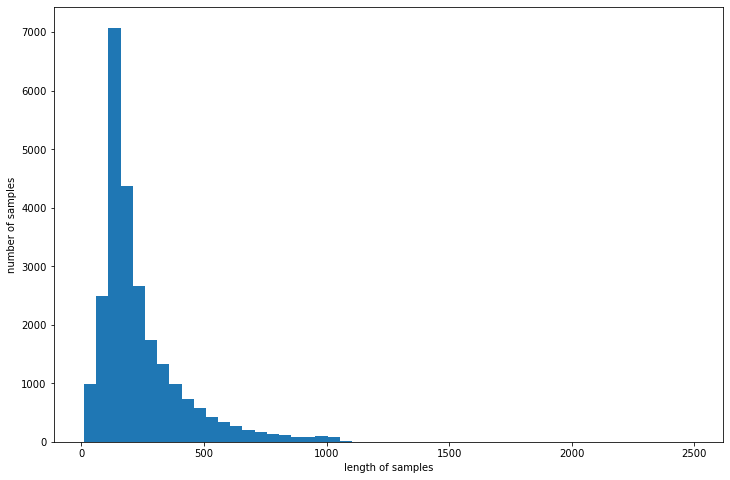

In [9]:
#(9) sample의 문장 구성에 따른 빈도 확인하기. 
plt.figure(figsize=(12,8))
plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
#(10) 총 단어 갯수에 맞춰 재분할하기.
INPUT_DIM = 5000
(X_train, y_train), (X_test,y_test) = imdb.load_data(
    num_words=INPUT_DIM
)

#(11) 적절한 문장 길이 정의 후 패딩처리하기.  
max_len = 250
X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

#(12) train, test 데이터셋 차원 확인하기. 
X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((25000, 250), (25000,), (25000, 250), (25000,))

In [11]:
#10. LSTM 모델로 로이터 데이터셋 다중 분류하기. 
#(1) 모델 정의하기. 
model = Sequential([
    Embedding(INPUT_DIM, 120),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(60),
    Dense(1, activation='sigmoid')
])

#(2) 모델의 요약 정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 60)                30000     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 668,525
Trainable params: 668,525
Non-trainable params: 0
__________________________________________________

In [12]:
#(3) 모델의 컴파일 설정하기.  
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy')

#(4) checkpointer 객체 설정하기. 
MODEL_PATH = '../../model/imdb_best_LSTM_model.h5'
checkpointer = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

#(5) ealrystopping 객체 설정하기. 
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=25
)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=2500,
    batch_size=100,
    callbacks=[checkpointer, earlystopping],
    verbose=0
)

#(7) best 모델 할당하기. 
best_model = load_model(MODEL_PATH)

#(8) best 모델로 예측 및 평가하기.
best_model.evaluate(X_test_pad,y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.2984 - accuracy: 0.8756


[0.29838696122169495, 0.8755599856376648]

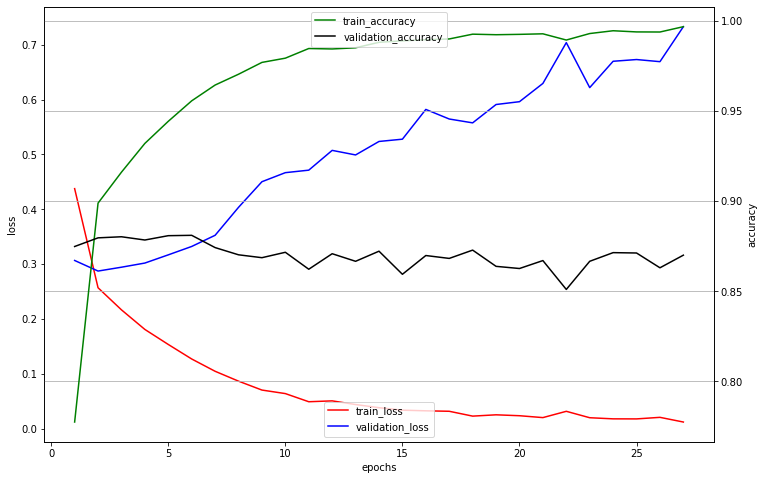

In [13]:
#(9) 훈련 과정 시각화하기. 
y_acc = model_fit.history['accuracy']
y_val_acc = model_fit.history['val_accuracy']

y_loss = model_fit.history['loss']
y_val_loss = model_fit.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.set_xlabel('epochs')

ax0.plot(x_len, y_loss, c='red', label='train_loss')
ax0.plot(x_len, y_val_loss, c='blue', label='validation_loss')
ax0.set_ylabel('loss')
ax0.legend(loc='lower center')

ax1.plot(x_len, y_acc, c='green', label='train_accuracy')
ax1.plot(x_len, y_val_acc, c='k', label='validation_accuracy')
ax1.set_ylabel('accuracy')
ax1.legend(loc='upper center')

plt.grid()
plt.show()